C:\Users\Dell\AppData\Local\Temp\ipykernel_48696\2391396173.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[extreme_mask].copy()


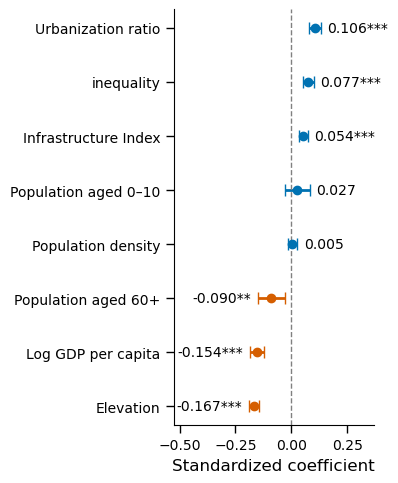

In [1]:
# =====================================
# Coefficient Plot (Dot–Whisker / Forest Plot)
# FIXED VERSION (no ecolor error)
# =====================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 1. 读取数据
# ==============================
file_path = r'C:\Users\Dell\Desktop\Global Urban\GID02_communities\Coastal_SUM_with_IRI_processed.xlsx'
df = pd.read_excel(file_path)

# 2. 列名清理（去空格、特殊字符）
# ==============================
df = df.rename(columns={
    'Per GDP': 'Per_GDP',
    'Urban ratio': 'Urban_ratio',
    'POP density': 'POP_density',
    'Floods_2020_pop_GID02': 'Floods_2020_pop',
    'Aging(60-)': 'Aging_60',
    'Young(0-10)': 'Young_0_10'
})
x = df['Floods_2020_Vulnerability']
y = df['Infra_Resilience_Index']
pop = df['POP_2020_GID02']
valid_mask = (x != 0) & (y != 0) & x.notna() & y.notna() & (pop > 0)
df = df[valid_mask].copy()

# 2.5 去除极端值（保留1%–99%）
x_q_low, x_q_high = x.quantile(0.01), x.quantile(0.99)
y_q_low, y_q_high = y.quantile(0.01), y.quantile(0.99)
extreme_mask = (x >= x_q_low) & (x <= x_q_high) & (y >= y_q_low) & (y <= y_q_high)
df = df[extreme_mask].copy()

# ==============================
# 3. 数据筛选（非缺失、非零）
# ==============================
cols_needed = [
    'Floods_2020_Vulnerability', 'Infra_Resilience_Index', 'POP_2020_GID02',
    'Per_GDP', 'Inequality', 'Urban_ratio', 'POP_density', 'DEM', 'GID_0'
]
df = df.dropna(subset=cols_needed)
df = df[
    (df['Floods_2020_Vulnerability'] > 0) &
    (df['Infra_Resilience_Index'] > 0) &
    (df['POP_2020_GID02'] > 0) &
    (df['Per_GDP'] > 0) &
    (df['POP_density'] > 0)
].copy()

# ==============================
# 4. 构建 IFBI 指标
# ==============================
df['IFBI'] = df['Floods_2020_pop'] * df['Floods_2020_Vulnerability'] 

# ==============================
# 5. 构建其他变量（交互项、log变换）
# ==============================
df['log_Per_GDP'] = np.log(df['Per_GDP'] + 1e-6)
df['InfraGap'] = 1 - df['Infra_Resilience_Index']
df['Inequality_x_InfraGap'] = df['Inequality'] * df['InfraGap']
df['log_IFBI'] = np.log(df['IFBI'] + 1e-6)

# ==============================
# 6. 修正索引和组标签
# ==============================
df = df.reset_index(drop=True)          # 重置索引
df['GID_0'] = df['GID_0'].astype(str)  # 确保分组标签为字符串
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_IFBI','log_Per_GDP','Inequality','Urban_ratio','POP_density','DEM','Infra_Resilience_Index'])

# ==============================
# 7. 定义公式
# ==============================
formula = "log_IFBI ~ log_Per_GDP + Inequality + Urban_ratio + POP_density + DEM + Aging_60 + Young_0_10 + Infra_Resilience_Index"

# ==============================
# 8. 拟合 MixedLM（随机截距：国家 GID_0）
# ==============================
md = mixedlm(formula, df, groups=df['GID_0'])
mdf = md.fit(reml=False)


# ==============================
# 1. 提取 MixedLM 结果
# ==============================
res = mdf  # MixedLM 结果

coef_df = pd.DataFrame({
    'variable': res.params.index,
    'coef': res.params.values,
    'se': res.bse.values,
    'pval': res.pvalues.values
})

coef_df = coef_df[~coef_df['variable'].isin(['Intercept', 'Group Var'])].copy()

# ==============================
# 2. 置信区间
# ==============================
coef_df['ci_low'] = coef_df['coef'] - 1.96 * coef_df['se']
coef_df['ci_high'] = coef_df['coef'] + 1.96 * coef_df['se']

# ==============================
# 3. 标准化系数
# ==============================
std_y = df['log_IFBI'].std()

std_factor = []
for var in coef_df['variable']:
    if var in df.columns:
        std_x = df[var].std()
        std_factor.append(std_x / std_y)
    else:
        std_factor.append(1.0)

coef_df['std_coef'] = coef_df['coef'] * std_factor
coef_df['std_ci_low'] = coef_df['ci_low'] * std_factor
coef_df['std_ci_high'] = coef_df['ci_high'] * std_factor

# ==============================
# 4. 显著性星号
# ==============================
def sig_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

coef_df['sig'] = coef_df['pval'].apply(sig_star)

# ==============================
# 5. 变量标签
# ==============================
label_map = {
    'log_Per_GDP': 'Log GDP per capita',
    'Inequality': 'inequality',
    'Urban_ratio': 'Urbanization ratio',
    'Urban_ratio_sq': 'Urbanization²',
    'POP_density': 'Population density',
    'DEM': 'Elevation',
    'Inequality_x_InfraGap': 'Inequality × Infrastructure gap',
    'Infra_Resilience_Index': 'Infrastructure Index',
    'Urban_x_Ineq': 'Urbanization × Inequality',
    'Aging_60': 'Population aged 60+',
    'Young_0_10': 'Population aged 0–10'
}

coef_df['label'] = coef_df['variable'].map(label_map).fillna(coef_df['variable'])

# ==============================
# 6. 排序
# ==============================
coef_df = coef_df.sort_values('std_coef').reset_index(drop=True)

# ==============================
# 全局字体设置（统一放大）
# ==============================
plt.rcParams.update({
    'font.size': 12,            # 全局默认字体
    'axes.labelsize': 14,       # 坐标轴标题
    'axes.titlesize': 14,
    'xtick.labelsize': 12,      # x轴刻度
    'ytick.labelsize': 12,      # y轴刻度
    'legend.fontsize': 12,
    'figure.titlesize': 14
})

# ==============================
# 7. 绘制森林图（逐条画，避免 ecolor 报错）
# ==============================
plt.figure(figsize=(4, 5))
# 横轴动态范围
x_min = min(coef_df['std_ci_low'].min() - 1.8*abs(coef_df['std_ci_low'].min()), 0)
x_max = max(coef_df['std_ci_high'].max() + 1.8*abs(coef_df['std_ci_high'].max()), 0)

for i, row in coef_df.iterrows():
    color = '#0072B2' if row['std_coef'] > 0 else '#D55E00'

    plt.errorbar(
        x=row['std_coef'],
        y=i,
        xerr=[[row['std_coef'] - row['std_ci_low']],
              [row['std_ci_high'] - row['std_coef']]],
        fmt='o',
        color=color,
        ecolor=color,
        elinewidth=2,
        capsize=4
    )
    # === 控制标注与 CI 的水平间距（可调） ===
    offset = 0.03 # 推荐 0.01–0.03，根据图宽调整

    # 显著性标注（避免与 CI 重叠）
    x_text = (
        row['std_ci_high'] + offset
        if row['std_coef'] > 0
        else row['std_ci_low'] - offset
    )

    plt.text(
        x_text,
        i,
        f"{row['std_coef']:.3f}{row['sig']}",
        va='center',
        ha='left' if row['std_coef'] > 0 else 'right',
        fontsize=10
    )

# y 轴标签
plt.yticks(range(len(coef_df)), coef_df['label'])

# 0 参考线
plt.axvline(0, linestyle='--', color='gray', linewidth=1)

# ==============================
# 添加刻度线
# ==============================
plt.tick_params(axis='x', direction='out', length=6, width=1, colors='black', labelsize=10)
plt.tick_params(axis='y', direction='out', length=6, width=1, colors='black', labelsize=10)


# ==============================
# 8. 美化
# ==============================
# 🔴 固定横坐标范围
plt.xlim(x_min, x_max)
# 横纵轴标签
plt.xlabel('Standardized coefficient', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_48696\2343890106.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[extreme_mask].copy()


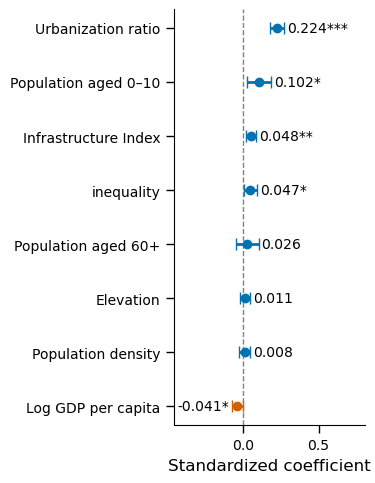

In [2]:
# =====================================
# Coefficient Plot (Dot–Whisker / Forest Plot)
# FIXED VERSION (no ecolor error)
# =====================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 1. 读取数据
# ==============================
file_path = r'C:\Users\Dell\Desktop\Global Urban\GID02_communities\Coastal_SUM_with_IRI_processed.xlsx'
df = pd.read_excel(file_path)

# 2. 列名清理（去空格、特殊字符）
# ==============================
df = df.rename(columns={
    'Per GDP': 'Per_GDP',
    'Urban ratio': 'Urban_ratio',
    'POP density': 'POP_density',
    'Floods_2020_pop_GID02': 'Floods_2020_pop',
    'Aging(60-)': 'Aging_60',
    'Young(0-10)': 'Young_0_10'
})

# 3. 筛选全球南方 (NS == 'S')
# ==============================
df = df[df['NS'] == 'N'].copy()

x = df['Floods_2020_Vulnerability']
y = df['Infra_Resilience_Index']
pop = df['POP_2020_GID02']
valid_mask = (x != 0) & (y != 0) & x.notna() & y.notna() & (pop > 0)
df = df[valid_mask].copy()

# 2.5 去除极端值（保留1%–99%）
x_q_low, x_q_high = x.quantile(0.01), x.quantile(0.99)
y_q_low, y_q_high = y.quantile(0.01), y.quantile(0.99)
extreme_mask = (x >= x_q_low) & (x <= x_q_high) & (y >= y_q_low) & (y <= y_q_high)
df = df[extreme_mask].copy()

# ==============================
# 3. 数据筛选（非缺失、非零）
# ==============================
cols_needed = [
    'Floods_2020_Vulnerability', 'Infra_Resilience_Index', 'POP_2020_GID02',
    'Per_GDP', 'Inequality', 'Urban_ratio', 'POP_density', 'DEM', 'GID_0'
]
df = df.dropna(subset=cols_needed)
df = df[
    (df['Floods_2020_Vulnerability'] > 0) &
    (df['Infra_Resilience_Index'] > 0) &
    (df['POP_2020_GID02'] > 0) &
    (df['Per_GDP'] > 0) &
    (df['POP_density'] > 0)
].copy()

# ==============================
# 4. 构建 IFBI 指标
# ==============================
df['IFBI'] = df['Floods_2020_pop'] * df['Floods_2020_Vulnerability'] 
#/ (df['Infra_Resilience_Index'] + 1e-6)

# ==============================
# 5. 构建其他变量（交互项、log变换）
# ==============================
df['log_Per_GDP'] = np.log(df['Per_GDP'] + 1e-6)
df['InfraGap'] = 1 - df['Infra_Resilience_Index']
df['Inequality_x_InfraGap'] = df['Inequality'] * df['InfraGap']
df['log_IFBI'] = np.log(df['IFBI'] + 1e-6)

# ==============================
# 6. 修正索引和组标签
# ==============================
df = df.reset_index(drop=True)          # 重置索引
df['GID_0'] = df['GID_0'].astype(str)  # 确保分组标签为字符串
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_IFBI','log_Per_GDP','Inequality','Urban_ratio','POP_density','DEM','Infra_Resilience_Index'])

# ==============================
# 7. 定义公式
# ==============================
formula = "log_IFBI ~ log_Per_GDP + Inequality + Urban_ratio + POP_density + DEM + Aging_60 + Young_0_10 + Infra_Resilience_Index"

# ==============================
# 8. 拟合 MixedLM（随机截距：国家 GID_0）
# ==============================
md = mixedlm(formula, df, groups=df['GID_0'])
mdf = md.fit(reml=False)


# ==============================
# 1. 提取 MixedLM 结果
# ==============================
res = mdf  # MixedLM 结果

coef_df = pd.DataFrame({
    'variable': res.params.index,
    'coef': res.params.values,
    'se': res.bse.values,
    'pval': res.pvalues.values
})

coef_df = coef_df[~coef_df['variable'].isin(['Intercept', 'Group Var'])].copy()

# ==============================
# 2. 置信区间
# ==============================
coef_df['ci_low'] = coef_df['coef'] - 1.96 * coef_df['se']
coef_df['ci_high'] = coef_df['coef'] + 1.96 * coef_df['se']

# ==============================
# 3. 标准化系数
# ==============================
std_y = df['log_IFBI'].std()

std_factor = []
for var in coef_df['variable']:
    if var in df.columns:
        std_x = df[var].std()
        std_factor.append(std_x / std_y)
    else:
        std_factor.append(1.0)

coef_df['std_coef'] = coef_df['coef'] * std_factor
coef_df['std_ci_low'] = coef_df['ci_low'] * std_factor
coef_df['std_ci_high'] = coef_df['ci_high'] * std_factor

# ==============================
# 4. 显著性星号
# ==============================
def sig_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

coef_df['sig'] = coef_df['pval'].apply(sig_star)

# ==============================
# 5. 变量标签
# ==============================
label_map = {
    'log_Per_GDP': 'Log GDP per capita',
    'Inequality': 'inequality',
    'Urban_ratio': 'Urbanization ratio',
    'Urban_ratio_sq': 'Urbanization²',
    'POP_density': 'Population density',
    'DEM': 'Elevation',
    'Infra_Resilience_Index': 'Infrastructure Index',
    'Inequality_x_InfraGap': 'Inequality × Infrastructure gap',
    'Urban_x_Ineq': 'Urbanization × Inequality',
    'Aging_60': 'Population aged 60+',
    'Young_0_10': 'Population aged 0–10'
}

coef_df['label'] = coef_df['variable'].map(label_map).fillna(coef_df['variable'])

# ==============================
# 6. 排序
# ==============================
coef_df = coef_df.sort_values('std_coef').reset_index(drop=True)

# ==============================
# 7. 绘制森林图（逐条画，避免 ecolor 报错）
# ==============================
plt.figure(figsize=(4, 5))
# 横轴动态范围
x_min = min(coef_df['std_ci_low'].min() - 5*abs(coef_df['std_ci_low'].min()), 0)
x_max = max(coef_df['std_ci_high'].max() + 2*abs(coef_df['std_ci_high'].max()), 0)

for i, row in coef_df.iterrows():
    color = '#0072B2' if row['std_coef'] > 0 else '#D55E00'

    plt.errorbar(
        x=row['std_coef'],
        y=i,
        xerr=[[row['std_coef'] - row['std_ci_low']],
              [row['std_ci_high'] - row['std_coef']]],
        fmt='o',
        color=color,
        ecolor=color,
        elinewidth=2,
        capsize=4
    )
    # === 控制标注与 CI 的水平间距（可调） ===
    offset = 0.02 # 推荐 0.01–0.03，根据图宽调整

    # 显著性标注（避免与 CI 重叠）
    x_text = (
        row['std_ci_high'] + offset
        if row['std_coef'] > 0
        else row['std_ci_low'] - offset
    )

    plt.text(
        x_text,
        i,
        f"{row['std_coef']:.3f}{row['sig']}",
        va='center',
        ha='left' if row['std_coef'] > 0 else 'right',
        fontsize=10
    )

# y 轴标签
plt.yticks(range(len(coef_df)), coef_df['label'])

# 0 参考线
plt.axvline(0, linestyle='--', color='gray', linewidth=1)

# ==============================
# 添加刻度线
# ==============================
plt.tick_params(axis='x', direction='out', length=6, width=1, colors='black', labelsize=10)
plt.tick_params(axis='y', direction='out', length=6, width=1, colors='black', labelsize=10)


# ==============================
# 8. 美化
# ==============================
# 🔴 固定横坐标范围
plt.xlim(x_min, x_max)
# 横纵轴标签
plt.xlabel('Standardized coefficient', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_48696\3663410970.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[extreme_mask].copy()


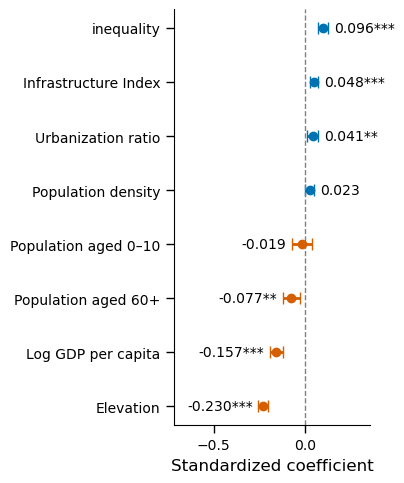

In [3]:
# =====================================
# Coefficient Plot (Dot–Whisker / Forest Plot)
# FIXED VERSION (no ecolor error)
# =====================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 1. 读取数据
# ==============================
file_path = r'C:\Users\Dell\Desktop\Global Urban\GID02_communities\Coastal_SUM_with_IRI_processed.xlsx'
df = pd.read_excel(file_path)

# 2. 列名清理（去空格、特殊字符）
# ==============================
df = df.rename(columns={
    'Per GDP': 'Per_GDP',
    'Urban ratio': 'Urban_ratio',
    'POP density': 'POP_density',
    'Floods_2020_pop_GID02': 'Floods_2020_pop',
    'Aging(60-)': 'Aging_60',
    'Young(0-10)': 'Young_0_10'
})

# 3. 筛选全球南方 (NS == 'S')
# ==============================
df = df[df['NS'] == 'S'].copy()

x = df['Floods_2020_Vulnerability']
y = df['Infra_Resilience_Index']
pop = df['POP_2020_GID02']
valid_mask = (x != 0) & (y != 0) & x.notna() & y.notna() & (pop > 0)
df = df[valid_mask].copy()

# 2.5 去除极端值（保留1%–99%）
x_q_low, x_q_high = x.quantile(0.01), x.quantile(0.99)
y_q_low, y_q_high = y.quantile(0.01), y.quantile(0.99)
extreme_mask = (x >= x_q_low) & (x <= x_q_high) & (y >= y_q_low) & (y <= y_q_high)
df = df[extreme_mask].copy()

# ==============================
# 3. 数据筛选（非缺失、非零）
# ==============================
cols_needed = [
    'Floods_2020_Vulnerability', 'Infra_Resilience_Index', 'POP_2020_GID02',
    'Per_GDP', 'Inequality', 'Urban_ratio', 'POP_density', 'DEM', 'GID_0'
]
df = df.dropna(subset=cols_needed)
df = df[
    (df['Floods_2020_Vulnerability'] > 0) &
    (df['Infra_Resilience_Index'] > 0) &
    (df['POP_2020_GID02'] > 0) &
    (df['Per_GDP'] > 0) &
    (df['POP_density'] > 0)
].copy()

# ==============================
# 4. 构建 IFBI 指标
# ==============================
df['IFBI'] = df['Floods_2020_pop'] * df['Floods_2020_Vulnerability']

# ==============================
# 5. 构建其他变量（交互项、log变换）
# ==============================
df['log_Per_GDP'] = np.log(df['Per_GDP'] + 1e-6)
df['InfraGap'] = 1 - df['Infra_Resilience_Index']
df['Inequality_x_InfraGap'] = df['Inequality'] * df['InfraGap']
df['log_IFBI'] = np.log(df['IFBI'] + 1e-6)

# ==============================
# 6. 修正索引和组标签
# ==============================
df = df.reset_index(drop=True)          # 重置索引
df['GID_0'] = df['GID_0'].astype(str)  # 确保分组标签为字符串
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_IFBI','log_Per_GDP','Inequality','Urban_ratio','POP_density','DEM','Infra_Resilience_Index'])

# ==============================
# 7. 定义公式
# ==============================
formula = "log_IFBI ~ log_Per_GDP + Inequality + Urban_ratio + POP_density + DEM + Aging_60 + Young_0_10 + Infra_Resilience_Index"

# ==============================
# 8. 拟合 MixedLM（随机截距：国家 GID_0）
# ==============================
md = mixedlm(formula, df, groups=df['GID_0'])
mdf = md.fit(reml=False)


# ==============================
# 1. 提取 MixedLM 结果
# ==============================
res = mdf  # MixedLM 结果

coef_df = pd.DataFrame({
    'variable': res.params.index,
    'coef': res.params.values,
    'se': res.bse.values,
    'pval': res.pvalues.values
})

coef_df = coef_df[~coef_df['variable'].isin(['Intercept', 'Group Var'])].copy()

# ==============================
# 2. 置信区间
# ==============================
coef_df['ci_low'] = coef_df['coef'] - 1.96 * coef_df['se']
coef_df['ci_high'] = coef_df['coef'] + 1.96 * coef_df['se']

# ==============================
# 3. 标准化系数
# ==============================
std_y = df['log_IFBI'].std()

std_factor = []
for var in coef_df['variable']:
    if var in df.columns:
        std_x = df[var].std()
        std_factor.append(std_x / std_y)
    else:
        std_factor.append(1.0)

coef_df['std_coef'] = coef_df['coef'] * std_factor
coef_df['std_ci_low'] = coef_df['ci_low'] * std_factor
coef_df['std_ci_high'] = coef_df['ci_high'] * std_factor

# ==============================
# 4. 显著性星号
# ==============================
def sig_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

coef_df['sig'] = coef_df['pval'].apply(sig_star)

# ==============================
# 5. 变量标签
# ==============================
label_map = {
    'log_Per_GDP': 'Log GDP per capita',
    'Inequality': 'inequality',
    'Urban_ratio': 'Urbanization ratio',
    'Urban_ratio_sq': 'Urbanization²',
    'POP_density': 'Population density',
    'DEM': 'Elevation',
    'Infra_Resilience_Index': 'Infrastructure Index',
    'Inequality_x_InfraGap': 'Inequality × Infrastructure gap',
    'Urban_x_Ineq': 'Urbanization × Inequality',
    'Aging_60': 'Population aged 60+',
    'Young_0_10': 'Population aged 0–10'
}

coef_df['label'] = coef_df['variable'].map(label_map).fillna(coef_df['variable'])

# ==============================
# 6. 排序
# ==============================
coef_df = coef_df.sort_values('std_coef').reset_index(drop=True)

# ==============================
# 7. 绘制森林图（逐条画，避免 ecolor 报错）
# ==============================
plt.figure(figsize=(4, 5))
# 横轴动态范围
x_min = min(coef_df['std_ci_low'].min() - 1.8*abs(coef_df['std_ci_low'].min()), 0)
x_max = max(coef_df['std_ci_high'].max() + 1.8*abs(coef_df['std_ci_high'].max()), 0)
#x_min =-1.0
#x_max =1.0
for i, row in coef_df.iterrows():
    color = '#0072B2' if row['std_coef'] > 0 else '#D55E00'

    plt.errorbar(
        x=row['std_coef'],
        y=i,
        xerr=[[row['std_coef'] - row['std_ci_low']],
              [row['std_ci_high'] - row['std_coef']]],
        fmt='o',
        color=color,
        ecolor=color,
        elinewidth=2,
        capsize=4
    )
    # === 控制标注与 CI 的水平间距（可调） ===
    offset = 0.03 # 推荐 0.01–0.03，根据图宽调整

    # 显著性标注（避免与 CI 重叠）
    x_text = (
        row['std_ci_high'] + offset
        if row['std_coef'] > 0
        else row['std_ci_low'] - offset
    )

    plt.text(
        x_text,
        i,
        f"{row['std_coef']:.3f}{row['sig']}",
        va='center',
        ha='left' if row['std_coef'] > 0 else 'right',
        fontsize=10
    )

# y 轴标签
plt.yticks(range(len(coef_df)), coef_df['label'])

# 0 参考线
plt.axvline(0, linestyle='--', color='gray', linewidth=1)

# ==============================
# 添加刻度线
# ==============================
plt.tick_params(axis='x', direction='out', length=6, width=1, colors='black', labelsize=10)
plt.tick_params(axis='y', direction='out', length=6, width=1, colors='black', labelsize=10)


# ==============================
# 8. 美化
# ==============================
# 🔴 固定横坐标范围
plt.xlim(x_min, x_max)
# 横纵轴标签
plt.xlabel('Standardized coefficient', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()


✅ Low-income countries: coef=5.646, p=0.0021
✅ Lower-middle-income countries: coef=2.197, p=0.0035
✅ Upper-middle-income countries: coef=3.901, p=4.48e-06
✅ High-income countries: coef=2.508, p=0.00196


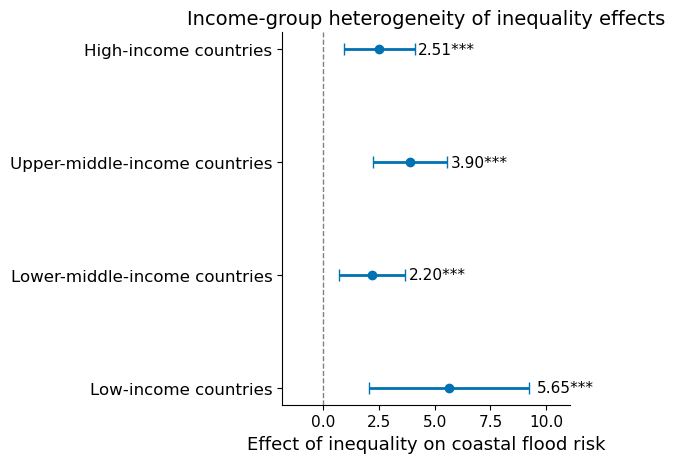

In [4]:
# =====================================
# Income Group Heterogeneity Analysis
# Inequality effect on coastal flood risk
# MixedLM + Forest Plot
# =====================================

import pandas as pd
import numpy as np
from statsmodels.formula.api import mixedlm
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 0. 全局绘图字体（期刊级）
# ==============================
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 13,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11
})

# ==============================
# 1. 读取数据
# ==============================
file_path = r'C:\Users\Dell\Desktop\Global Urban\GID02_communities\Coastal_SUM_with_IRI_processed.xlsx'
df = pd.read_excel(file_path)

# ==============================
# 2. 列名清理
# ==============================
df = df.rename(columns={
    'Per GDP': 'Per_GDP',
    'Urban ratio': 'Urban_ratio',
    'POP density': 'POP_density',
    'Floods_2020_pop_GID02': 'Floods_2020_pop',
    'Aging(60-)': 'Aging_60',
    'Young(0-10)': 'Young_0_10'
})

# ==============================
# 3. 基础变量筛选
# ==============================
x = df['Floods_2020_Vulnerability']
y = df['Infra_Resilience_Index']
pop = df['POP_2020_GID02']

valid_mask = (
    (x > 0) & (y > 0) &
    x.notna() & y.notna() &
    (pop > 0)
)
df = df[valid_mask].copy()

# 去除 1%–99% 极端值
x_q_low, x_q_high = x.quantile(0.01), x.quantile(0.99)
y_q_low, y_q_high = y.quantile(0.01), y.quantile(0.99)

df = df[
    (df['Floods_2020_Vulnerability'].between(x_q_low, x_q_high)) &
    (df['Infra_Resilience_Index'].between(y_q_low, y_q_high))
].copy()

# ==============================
# 4. 构建指标
# ==============================
df['IFBI'] = df['Floods_2020_pop'] * df['Floods_2020_Vulnerability']
df['log_IFBI'] = np.log(df['IFBI'] + 1e-6)
df['log_Per_GDP'] = np.log(df['Per_GDP'] + 1e-6)
df['InfraGap'] = 1 - df['Infra_Resilience_Index']

df['GID_0'] = df['GID_0'].astype(str)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[
    'log_IFBI', 'log_Per_GDP', 'Inequality',
    'Urban_ratio', 'POP_density', 'DEM',
    'Infra_Resilience_Index', 'Income Group'
])

# ==============================
# 5. 模型公式
# ==============================
formula = (
    "log_IFBI ~ log_Per_GDP + Inequality + Urban_ratio + "
    "POP_density + DEM + Aging_60 + Young_0_10 + Infra_Resilience_Index"
)

# ==============================
# 6. 按 Income Group 循环建模
# ==============================
income_groups = [
    'Low-income countries',
    'Lower-middle-income countries',
    'Upper-middle-income countries',
    'High-income countries'
]

results = []

for group in income_groups:
    df_g = df[df['Income Group'] == group].copy()

    # 样本与国家数控制
    if len(df_g) < 10 or df_g['GID_0'].nunique() < 3:
        print(f"⚠️ 跳过 {group}（样本或国家数不足）")
        continue

    try:
        md = mixedlm(formula, df_g, groups=df_g['GID_0'])
        mdf = md.fit(reml=False, disp=False)

        coef = mdf.params['Inequality']
        se = mdf.bse['Inequality']
        pval = mdf.pvalues['Inequality']

        results.append({
            'Group': group,
            'coef': coef,
            'se': se,
            'pval': pval,
            'ci_low': coef - 1.96 * se,
            'ci_high': coef + 1.96 * se
        })

        print(f"✅ {group}: coef={coef:.3f}, p={pval:.3g}")

    except Exception as e:
        print(f"❌ {group} 模型失败：{e}")

# ==============================
# 7. 整理结果
# ==============================
res_df = pd.DataFrame(results)

def sig_star(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

res_df['sig'] = res_df['pval'].apply(sig_star)

order_map = {
    'Low-income countries': 0,
    'Lower-middle-income countries': 1,
    'Upper-middle-income countries': 2,
    'High-income countries': 3
}

res_df['order'] = res_df['Group'].map(order_map)
res_df = res_df.sort_values('order').reset_index(drop=True)

# ==============================
# 8. Income Group 森林图
# ==============================
plt.figure(figsize=(6, 4.8))

x_left = min(res_df['ci_low'].min(), 0)
x_right = max(res_df['ci_high'].max(), 0)
x_margin = 0.2 * (x_right - x_left)

plt.xlim(x_left - x_margin, x_right + x_margin)

for i, row in res_df.iterrows():
    color = '#0072B2' if row['coef'] > 0 else '#D55E00'

    plt.errorbar(
        row['coef'],
        i,
        xerr=[[row['coef'] - row['ci_low']],
              [row['ci_high'] - row['coef']]],
        fmt='o',
        color=color,
        ecolor=color,
        elinewidth=2,
        capsize=4,
        zorder=3
    )

    ci_width = row['ci_high'] - row['ci_low']
    offset = 0.05 * ci_width

    if row['coef'] > 0:
        x_text = row['ci_high'] + offset
        ha = 'left'
    else:
        x_text = row['ci_low'] - offset
        ha = 'right'

    plt.text(
        x_text,
        i,
        f"{row['coef']:.2f}{row['sig']}",
        va='center',
        ha=ha,
        fontsize=11
    )

plt.yticks(range(len(res_df)), res_df['Group'], fontsize=12)
plt.axvline(0, linestyle='--', color='gray', linewidth=1)

plt.xlabel('Effect of inequality on coastal flood risk', fontsize=13)
plt.title('Income-group heterogeneity of inequality effects', fontsize=14)

sns.despine()
plt.tight_layout()
plt.show()


In [5]:
# =====================================
# SHAP Analysis for High-income countries
# =====================================

import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ==============================
# 1. 读取数据
# ==============================
file_path = r'C:\Users\Dell\Desktop\Global Urban\GID02_communities\Coastal_SUM_with_IRI_processed.xlsx'
df = pd.read_excel(file_path)

# ==============================
# 2. 变量重命名（防止空格问题）
# ==============================
df = df.rename(columns={
    'Per GDP': 'Per_GDP',
    'Urban ratio': 'Urban_ratio',
    'POP density': 'POP_density',
    'Floods_2020_pop_GID02': 'Floods_2020_pop',
    'Aging(60-)': 'Aging_60',
    'Young(0-10)': 'Young_0_10'
})

# ==============================
# 3. 仅筛选 Low-income countries
# ==============================
df = df[df['Income Group'] == 'High-income countries'].copy()

# ==============================
# 4. 基础清洗
# ==============================
df = df.replace([np.inf, -np.inf], np.nan)

df = df.dropna(subset=[
    'Floods_2020_Vulnerability',
    'Infra_Resilience_Index',
    'POP_2020_GID02',
    'Per_GDP',
    'Inequality',
    'Urban_ratio',
    'POP_density',
    'DEM',
    'Aging_60',
    'Young_0_10'
])

# ==============================
# 5. 构建目标变量（Coastal Risk）
# ==============================
df['Coastal_Risk'] = (
    df['Floods_2020_pop'] *
    df['Floods_2020_Vulnerability'] 
)
df['Coastal_Risk'] = np.log(df['Coastal_Risk'] + 1e-6)
# log GDP
df['log_Per_GDP'] = np.log(df['Per_GDP'] + 1e-6)

# ==============================
# 6. 特征与目标
# ==============================
features = [
    'log_Per_GDP',
    'Inequality',
    'Urban_ratio',
    'POP_density',
    'DEM',
    'Infra_Resilience_Index'
]

target = 'Coastal_Risk'

df_model = df[features + [target]].dropna().copy()

# ==============================
# 7. 去极端值（IQR，10–90%）
# ==============================
def remove_outliers_iqr(df, cols):
    mask = pd.Series(True, index=df.index)
    for col in cols:
        Q1 = df[col].quantile(0.1)
        Q3 = df[col].quantile(0.9)
        IQR = Q3 - Q1
        mask &= df[col].between(Q1 - 1 * IQR, Q3 + 1 * IQR)
    return df[mask]

df_model = remove_outliers_iqr(df_model, features + [target])

# ==============================
# 8. 特征归一化
# ==============================
scaler = MinMaxScaler()
X = pd.DataFrame(
    scaler.fit_transform(df_model[features]),
    columns=features,
    index=df_model.index
)

y = df_model[target]   # ⚠️ 必须是 Series

# ==============================
# 9. 拆分数据
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

# ==============================
# 10. 训练 XGBoost
# ==============================
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# ==============================
# 11. SHAP 解释（关键）
# ==============================
explainer = shap.Explainer(model, X_train)

shap_values = explainer(
    X,
    check_additivity=False   # ✔ 正确位置
)

# ==============================
# 获取模型预测值
y_pred = model.predict(X)


import shap
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# -----------------------------
# 0️⃣ 去掉 hdi_values=0 的点
# -----------------------------
mask_nonzero = X["Inequality"].values != 0
hdi_values = X["Inequality"].values[mask_nonzero]
shap_hdi = shap_values[:, "Inequality"].values[mask_nonzero]
colors = y_pred[mask_nonzero]  # 用预测值着色

# -----------------------------
# 1️⃣ LOWESS 拟合
# -----------------------------
lowess = sm.nonparametric.lowess
fitted = lowess(shap_hdi, hdi_values, frac=0.3, return_sorted=True)

# -----------------------------
# 2️⃣ 置信区间估计（bootstrapping）
# -----------------------------
n_boot = 200
bootstrap_curves = []
x_vals = np.linspace(hdi_values.min(), hdi_values.max(), 200)

for _ in range(n_boot):
    idx = np.random.choice(range(len(hdi_values)), size=len(hdi_values), replace=True)
    sample_hdi = hdi_values[idx]
    sample_shap = shap_hdi[idx]
    curve = lowess(sample_shap, sample_hdi, frac=0.3, xvals=x_vals)
    bootstrap_curves.append(curve)

bootstrap_curves = np.array(bootstrap_curves)
lower = np.percentile(bootstrap_curves, 2.5, axis=0)
upper = np.percentile(bootstrap_curves, 97.5, axis=0)
median = np.median(bootstrap_curves, axis=0)

# -----------------------------
# 3️⃣ 全局字体与样式（去网格）
# -----------------------------
plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 20,
    "axes.labelsize": 22,
    "axes.titlesize": 22,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "axes.grid": False   # ❌ 关闭网格
})

# -----------------------------
# 4️⃣ 绘图
# -----------------------------
fig, ax = plt.subplots(figsize=(9, 5))

# 散点图
sc = ax.scatter(hdi_values, shap_hdi, c=colors, cmap='RdBu_r', alpha=1, edgecolor='none')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Predicted Coastal Flood Risk", fontsize=20)

# LOWESS 拟合曲线
ax.plot(x_vals, median, color='darkred', linewidth=2.5, label="LOWESS fit")

# 置信区间
ax.fill_between(x_vals, lower, upper, color='red', alpha=0.2, label="95% CI")

# 标签与图例
ax.set_xlabel("Inequality", fontsize=22)
ax.set_ylabel("SHAP value for Inequality", fontsize=22)
ax.legend(frameon=False, fontsize=16, loc='upper left')

# -----------------------------
# 5️⃣ 设置四周边框为黑色
# -----------------------------
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(1.5)

# -----------------------------
# 6️⃣ 显示横纵坐标刻度线
# -----------------------------
ax.tick_params(axis='x', direction='in', color='black', length=6, width=1.2)
ax.tick_params(axis='y', direction='in', color='black', length=6, width=1.2)

plt.tight_layout()
plt.show()


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# =====================================
# SHAP Analysis for Upper-middle-income countries
# =====================================

import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ==============================
# 1. 读取数据
# ==============================
file_path = r'C:\Users\Dell\Desktop\Global Urban\GID02_communities\Coastal_SUM_with_IRI_processed.xlsx'
df = pd.read_excel(file_path)

# ==============================
# 2. 变量重命名（防止空格问题）
# ==============================
df = df.rename(columns={
    'Per GDP': 'Per_GDP',
    'Urban ratio': 'Urban_ratio',
    'POP density': 'POP_density',
    'Floods_2020_pop_GID02': 'Floods_2020_pop',
    'Aging(60-)': 'Aging_60',
    'Young(0-10)': 'Young_0_10'
})

# ==============================
# 3. 仅筛选 Low-income countries
# ==============================
df = df[df['Income Group'] == 'Upper-middle-income countries'].copy()

# ==============================
# 4. 基础清洗
# ==============================
df = df.replace([np.inf, -np.inf], np.nan)

df = df.dropna(subset=[
    'Floods_2020_Vulnerability',
    'Infra_Resilience_Index',
    'POP_2020_GID02',
    'Per_GDP',
    'Inequality',
    'Urban_ratio',
    'POP_density',
    'DEM',
    'Aging_60',
    'Young_0_10'
])

# ==============================
# 5. 构建目标变量（Coastal Risk）
# ==============================
df['Coastal_Risk'] = (
    df['Floods_2020_pop'] *
    df['Floods_2020_Vulnerability'] 
)
df['Coastal_Risk'] = np.log(df['Coastal_Risk'] + 1e-6)
# log GDP
df['log_Per_GDP'] = np.log(df['Per_GDP'] + 1e-6)

# ==============================
# 6. 特征与目标
# ==============================
features = [
    'log_Per_GDP',
    'Inequality',
    'Urban_ratio',
    'POP_density',
    'DEM',
    'Infra_Resilience_Index'
]

target = 'Coastal_Risk'

df_model = df[features + [target]].dropna().copy()

# ==============================
# 7. 去极端值（IQR，10–90%）
# ==============================
def remove_outliers_iqr(df, cols):
    mask = pd.Series(True, index=df.index)
    for col in cols:
        Q1 = df[col].quantile(0.1)
        Q3 = df[col].quantile(0.9)
        IQR = Q3 - Q1
        mask &= df[col].between(Q1 - 1 * IQR, Q3 + 1 * IQR)
    return df[mask]

df_model = remove_outliers_iqr(df_model, features + [target])

# ==============================
# 8. 特征归一化
# ==============================
scaler = MinMaxScaler()
X = pd.DataFrame(
    scaler.fit_transform(df_model[features]),
    columns=features,
    index=df_model.index
)

y = df_model[target]   # ⚠️ 必须是 Series

# ==============================
# 9. 拆分数据
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

# ==============================
# 10. 训练 XGBoost
# ==============================
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# ==============================
# 11. SHAP 解释（关键）
# ==============================
explainer = shap.Explainer(model, X_train)

shap_values = explainer(
    X,
    check_additivity=False   # ✔ 正确位置
)

# ==============================
# 获取模型预测值
y_pred = model.predict(X)


import shap
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# -----------------------------
# 0️⃣ 去掉 hdi_values=0 的点
# -----------------------------
mask_nonzero = X["Inequality"].values != 0
hdi_values = X["Inequality"].values[mask_nonzero]
shap_hdi = shap_values[:, "Inequality"].values[mask_nonzero]
colors = y_pred[mask_nonzero]  # 用预测值着色

# -----------------------------
# 1️⃣ LOWESS 拟合
# -----------------------------
lowess = sm.nonparametric.lowess
fitted = lowess(shap_hdi, hdi_values, frac=0.3, return_sorted=True)

# -----------------------------
# 2️⃣ 置信区间估计（bootstrapping）
# -----------------------------
n_boot = 200
bootstrap_curves = []
x_vals = np.linspace(hdi_values.min(), hdi_values.max(), 200)

for _ in range(n_boot):
    idx = np.random.choice(range(len(hdi_values)), size=len(hdi_values), replace=True)
    sample_hdi = hdi_values[idx]
    sample_shap = shap_hdi[idx]
    curve = lowess(sample_shap, sample_hdi, frac=0.3, xvals=x_vals)
    bootstrap_curves.append(curve)

bootstrap_curves = np.array(bootstrap_curves)
lower = np.percentile(bootstrap_curves, 2.5, axis=0)
upper = np.percentile(bootstrap_curves, 97.5, axis=0)
median = np.median(bootstrap_curves, axis=0)

# -----------------------------
# 3️⃣ 全局字体与样式（去网格）
# -----------------------------
plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 20,
    "axes.labelsize": 22,
    "axes.titlesize": 22,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "axes.grid": False   # ❌ 关闭网格
})

# -----------------------------
# 4️⃣ 绘图
# -----------------------------
fig, ax = plt.subplots(figsize=(9, 5))

# 散点图
sc = ax.scatter(hdi_values, shap_hdi, c=colors, cmap='RdBu_r', alpha=1, edgecolor='none')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Predicted Coastal Flood Risk", fontsize=20)

# LOWESS 拟合曲线
ax.plot(x_vals, median, color='darkred', linewidth=2.5, label="LOWESS fit")

# 置信区间
ax.fill_between(x_vals, lower, upper, color='red', alpha=0.2, label="95% CI")

# 标签与图例
ax.set_xlabel("Inequality", fontsize=22)
ax.set_ylabel("SHAP value for Inequality", fontsize=22)
ax.legend(frameon=False, fontsize=16, loc='upper left')

# -----------------------------
# 5️⃣ 设置四周边框为黑色
# -----------------------------
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(1.5)

# -----------------------------
# 6️⃣ 显示横纵坐标刻度线
# -----------------------------
ax.tick_params(axis='x', direction='in', color='black', length=6, width=1.2)
ax.tick_params(axis='y', direction='in', color='black', length=6, width=1.2)

plt.tight_layout()
plt.show()


In [ ]:
# =====================================
# SHAP Analysis for Lower-middle-income countries
# =====================================

import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ==============================
# 1. 读取数据
# ==============================
file_path = r'C:\Users\Dell\Desktop\Global Urban\GID02_communities\Coastal_SUM_with_IRI_processed.xlsx'
df = pd.read_excel(file_path)

# ==============================
# 2. 变量重命名（防止空格问题）
# ==============================
df = df.rename(columns={
    'Per GDP': 'Per_GDP',
    'Urban ratio': 'Urban_ratio',
    'POP density': 'POP_density',
    'Floods_2020_pop_GID02': 'Floods_2020_pop',
    'Aging(60-)': 'Aging_60',
    'Young(0-10)': 'Young_0_10'
})

# ==============================
# 3. 仅筛选 Low-income countries
# ==============================
df = df[df['Income Group'] == 'Lower-middle-income countries'].copy()

# ==============================
# 4. 基础清洗
# ==============================
df = df.replace([np.inf, -np.inf], np.nan)

df = df.dropna(subset=[
    'Floods_2020_Vulnerability',
    'Infra_Resilience_Index',
    'POP_2020_GID02',
    'Per_GDP',
    'Inequality',
    'Urban_ratio',
    'POP_density',
    'DEM',
    'Aging_60',
    'Young_0_10'
])

# ==============================
# 5. 构建目标变量（Coastal Risk）
# ==============================
df['Coastal_Risk'] = (
    df['Floods_2020_pop'] *
    df['Floods_2020_Vulnerability'] 
)
df['Coastal_Risk'] = np.log(df['Coastal_Risk'] + 1e-6)
# log GDP
df['log_Per_GDP'] = np.log(df['Per_GDP'] + 1e-6)

# ==============================
# 6. 特征与目标
# ==============================
features = [
    'log_Per_GDP',
    'Inequality',
    'Urban_ratio',
    'POP_density',
    'DEM',
    'Infra_Resilience_Index'
]

target = 'Coastal_Risk'

df_model = df[features + [target]].dropna().copy()

# ==============================
# 7. 去极端值（IQR，10–90%）
# ==============================
def remove_outliers_iqr(df, cols):
    mask = pd.Series(True, index=df.index)
    for col in cols:
        Q1 = df[col].quantile(0.1)
        Q3 = df[col].quantile(0.9)
        IQR = Q3 - Q1
        mask &= df[col].between(Q1 - 1 * IQR, Q3 + 1 * IQR)
    return df[mask]

df_model = remove_outliers_iqr(df_model, features + [target])

# ==============================
# 8. 特征归一化
# ==============================
scaler = MinMaxScaler()
X = pd.DataFrame(
    scaler.fit_transform(df_model[features]),
    columns=features,
    index=df_model.index
)

y = df_model[target]   # ⚠️ 必须是 Series

# ==============================
# 9. 拆分数据
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

# ==============================
# 10. 训练 XGBoost
# ==============================
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# ==============================
# 11. SHAP 解释（关键）
# ==============================
explainer = shap.Explainer(model, X_train)

shap_values = explainer(
    X,
    check_additivity=False   # ✔ 正确位置
)

# ==============================
# 获取模型预测值
y_pred = model.predict(X)


import shap
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# -----------------------------
# 0️⃣ 去掉 hdi_values=0 的点
# -----------------------------
mask_nonzero = X["Inequality"].values != 0
hdi_values = X["Inequality"].values[mask_nonzero]
shap_hdi = shap_values[:, "Inequality"].values[mask_nonzero]
colors = y_pred[mask_nonzero]  # 用预测值着色

# -----------------------------
# 1️⃣ LOWESS 拟合
# -----------------------------
lowess = sm.nonparametric.lowess
fitted = lowess(shap_hdi, hdi_values, frac=0.3, return_sorted=True)

# -----------------------------
# 2️⃣ 置信区间估计（bootstrapping）
# -----------------------------
n_boot = 200
bootstrap_curves = []
x_vals = np.linspace(hdi_values.min(), hdi_values.max(), 200)

for _ in range(n_boot):
    idx = np.random.choice(range(len(hdi_values)), size=len(hdi_values), replace=True)
    sample_hdi = hdi_values[idx]
    sample_shap = shap_hdi[idx]
    curve = lowess(sample_shap, sample_hdi, frac=0.3, xvals=x_vals)
    bootstrap_curves.append(curve)

bootstrap_curves = np.array(bootstrap_curves)
lower = np.percentile(bootstrap_curves, 2.5, axis=0)
upper = np.percentile(bootstrap_curves, 97.5, axis=0)
median = np.median(bootstrap_curves, axis=0)

# -----------------------------
# 3️⃣ 全局字体与样式（去网格）
# -----------------------------
plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 20,
    "axes.labelsize": 22,
    "axes.titlesize": 22,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "axes.grid": False   # ❌ 关闭网格
})

# -----------------------------
# 4️⃣ 绘图
# -----------------------------
fig, ax = plt.subplots(figsize=(9, 5))

# 散点图
sc = ax.scatter(hdi_values, shap_hdi, c=colors, cmap='RdBu_r', alpha=1, edgecolor='none')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Predicted Coastal Flood Risk", fontsize=20)

# LOWESS 拟合曲线
ax.plot(x_vals, median, color='darkred', linewidth=2.5, label="LOWESS fit")

# 置信区间
ax.fill_between(x_vals, lower, upper, color='red', alpha=0.2, label="95% CI")

# 标签与图例
ax.set_xlabel("Inequality", fontsize=22)
ax.set_ylabel("SHAP value for Inequality", fontsize=22)
ax.legend(frameon=False, fontsize=16, loc='lower right')

# -----------------------------
# 5️⃣ 设置四周边框为黑色
# -----------------------------
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(1.5)

# -----------------------------
# 6️⃣ 显示横纵坐标刻度线
# -----------------------------
ax.tick_params(axis='x', direction='in', color='black', length=6, width=1.2)
ax.tick_params(axis='y', direction='in', color='black', length=6, width=1.2)

plt.tight_layout()
plt.show()


In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# -----------------------------
# 0️⃣ 去掉 hdi_values=0 的点
# -----------------------------
mask_nonzero = X["Inequality"].values != 0
hdi_values = X["Inequality"].values[mask_nonzero]
shap_hdi = shap_values[:, "Inequality"].values[mask_nonzero]
colors = y_pred[mask_nonzero]  # 用预测值着色

# -----------------------------
# 1️⃣ LOWESS 拟合
# -----------------------------
lowess = sm.nonparametric.lowess
fitted = lowess(shap_hdi, hdi_values, frac=0.3, return_sorted=True)

# -----------------------------
# 2️⃣ 置信区间估计（bootstrapping）
# -----------------------------
n_boot = 200
bootstrap_curves = []
x_vals = np.linspace(hdi_values.min(), hdi_values.max(), 200)

for _ in range(n_boot):
    idx = np.random.choice(range(len(hdi_values)), size=len(hdi_values), replace=True)
    sample_hdi = hdi_values[idx]
    sample_shap = shap_hdi[idx]
    curve = lowess(sample_shap, sample_hdi, frac=0.3, xvals=x_vals)
    bootstrap_curves.append(curve)

bootstrap_curves = np.array(bootstrap_curves)
lower = np.percentile(bootstrap_curves, 2.5, axis=0)
upper = np.percentile(bootstrap_curves, 97.5, axis=0)
median = np.median(bootstrap_curves, axis=0)

# -----------------------------
# 3️⃣ 全局字体与样式（去网格）
# -----------------------------
plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 20,
    "axes.labelsize": 22,
    "axes.titlesize": 22,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "axes.grid": False   # ❌ 关闭网格
})

# -----------------------------
# 4️⃣ 绘图
# -----------------------------
fig, ax = plt.subplots(figsize=(9, 5))

# 散点图
sc = ax.scatter(hdi_values, shap_hdi, c=colors, cmap='RdBu_r', alpha=1, edgecolor='none')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Predicted Coastal Flood Risk", fontsize=20)

# LOWESS 拟合曲线
ax.plot(x_vals, median, color='darkred', linewidth=2.5, label="LOWESS fit")

# 置信区间
ax.fill_between(x_vals, lower, upper, color='red', alpha=0.2, label="95% CI")

# 标签与图例
ax.set_xlabel("Inequality", fontsize=22)
ax.set_ylabel("SHAP value for Inequality", fontsize=22)
ax.legend(frameon=False, fontsize=16, loc='lower right')

# -----------------------------
# 5️⃣ 设置四周边框为黑色
# -----------------------------
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(1.5)

# -----------------------------
# 6️⃣ 显示横纵坐标刻度线
# -----------------------------
ax.tick_params(axis='x', direction='in', color='black', length=6, width=1.2)
ax.tick_params(axis='y', direction='in', color='black', length=6, width=1.2)

plt.tight_layout()
plt.show()
